## Introduction

This notebook illustrates how we can use NER to search for placenames in a corpus, and enhance a gazetteer. It uses two datesets to illustrate the concepts.

1) [Geograph](https://geograph.org.uk) 
This site invites users to take pictures in the UK and add descriptions. It has almost 7 million pictures, and the data are licenced using a CC By-SA licence, making them available for research as long as we keep the names of the users, and allow others to have access to any data we might create.

2) [Ordnance Survey](https://ordnancesurvey.co.uk/) 50k gazetteer
This gazetteer was published under a UK Open Government licence and contains all place name found on 1:50k maps in the UK. It is a legacy product (i.e. not used or updated any more), but it is suitable for our purposes.

We are going to look for names found in the Geograph data that don't exist in the gazetteer. Since we know that many names occur multiple times, we will do this locally, to increase the chances that we really find new names.

**The first block of our code reads in data and builds a simple spatial index for the gazetteer. We only need to do this once.**

In [1]:
import OSGridConverter #To convert from =SGB36 to WGS84
import pandas as pd #To use pandas for elegant data handling
import spacy #Our NLP tools
import matplotlib.pyplot as plt #To plot results

#Load a language model to do NLP
nlp = spacy.load("en_core_web_sm")

In [2]:
#First we read in the geograph data
geograph = pd.read_csv('./data/geograph_mini_corpus.csv', encoding='latin-1')
print(len(geograph))
geograph.head()

138639


,id,author,title,text,lon,lat
0,2749148,M J Richardson,Great Blasket Island - 1960,Looking northeast along the northwestern side ...,-10.534101,52.097794
1,635105,Bob Shires,White Beach Great Blasket,The only beach on Great Blasket as seen from t...,-10.514872,52.107609
2,635109,Bob Shires,Remaining homes on Great Blasket,The remaining few habited homes of the abandon...,-10.511764,52.104260
3,259349,Nigel Cox,Coumeenoole Bay,Viewed looking back from the Dunmore Head head...,-10.463579,52.109322
4,16917,Pam Brophy,Clogher Beach,The exact gpr for this beach is Q3153003375. T...,-10.463338,52.157867


This block demonstrates the NLP results for a single Geograph document. We use the entities later as potential toponyms.

In [3]:
#First we demonstrate how the NLP works for a single example document
doc = nlp(geograph.text[11])
spacy.displacy.render(doc, style="ent")
doc_nouns = list(doc.noun_chunks)
print("nouns:",doc_nouns)
for ent in doc.ents:
      print("NER:", ent.text, ent.label_)
          

nouns: [This field, sheep, line, trees, the eastern half, the square, The picture, more or less ENE, The square, a few residences, the minor road, the village, Dun Urlann]
NER: ENE ORG
NER: Dun Urlann ORG


Now we load the gazetteer data and create a simple spatial index.

In [4]:
#Read in the Ordnance Survey gazetteer
os_50k = pd.read_csv('./data/50kgaz2012.txt',sep=':', encoding='utf8', header=None)
os_50k.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,1,TQ6004,1066 Country Walk,TQ60,50,49.0,0,16.7,104500,560500,E,ES,E Susx,East Sussex,X,20-SEP-2011,I,199,0,0
1,2,TQ7715,1066 Country Walk,TQ60,50,54.7,0,31.5,115500,577500,E,ES,E Susx,East Sussex,X,20-SEP-2011,I,199,0,0
2,3,TQ7610,1066 Country Walk Bexhill Link,TQ60,50,52.0,0,30.5,110500,576500,E,ES,E Susx,East Sussex,X,20-SEP-2011,I,199,0,0
3,4,TQ8315,1066 Country Walk Hastings Link,TQ80,50,54.5,0,36.6,115500,583500,E,ES,E Susx,East Sussex,X,20-SEP-2011,I,199,0,0
4,5,NB5464,A' Beirghe,NB46,58,30.0,6,12.9,964500,154500,W,WI,N Eil,Na h-Eileanan an Iar,X,21-JAN-2003,U,8,0,0


In [5]:
#We need to create locations for each place name in decimal degrees using the data we loaded
#os_50k[20] = os_50k[4] + os_50k[5]/60
#os_50k[21] = os_50k[6] + os_50k[7]/60
#os_50k.loc[os_50k[10] == 'W', 21] = -1 * os_50k.loc[os_50k[10] == 'W', 21]

#Tidy up the gazetteer by dropping columns we won't use afterwards
os_trimmed = os_50k.drop([0,1,3,4,5,6,7,10,11,12,14,15,17,18,19], axis = 1)
os_trimmed.head()
#os_trimmed.columns = ['name','y','x','county','type','lat','lon']

os_trimmed.columns = ['name','y','x','county','type']
os_trimmed.head()

#Plot the gazetteer locations as a sanity check
#os_trimmed.plot.scatter(x = 'x', y = 'y')
print('The gazetteer has a total of', len(os_trimmed), 'entries.')


The gazetteer has a total of 258487 entries.


In [6]:
#We build a simple index using rectangular grid cells
#Each cell contains all placenames from the gazetteer for that cell and can be used to do a lookup
#cellSize determines the resolution in metres

cellSize = 10000
minx = os_trimmed['x'].min()
maxx = os_trimmed['x'].max()
miny = os_trimmed['y'].min()
maxy = os_trimmed['y'].max()

w = maxx - minx
h = maxy - miny

nc = int(w/cellSize) + 1
nr = int(h/cellSize) + 1

gaz = pd.DataFrame(index=range(nc),columns=range(nr))

#Now we populate the index with names
for index, row in os_trimmed.iterrows():
    i = int((row['x'] - minx)/cellSize)
    j = int((row['y'] - minx)/cellSize)
    name = row['name']
    
    if pd.isnull(gaz.at[i,j]):
        gaz.at[i,j] = {name}
    else:
        names = gaz.at[i,j]
        names.add(name)
        gaz.at[i,j] = names

Here we **draw a sample of documents** from the Geograph data and perform NER on those data. 

The sample can either be random, or we can define a search term and extract all records containg that term.

We can rerun this block to build a new sample. The size of this sample can also be changed.

In [7]:
# Create a sample of Geograph documents and run the NER pipeline
random = False

if random == True:
    m = 200
    sample = geograph.sample(n = m)
else:
    # Create a sample related to a word
    sample = geograph[geograph['text'].str.contains('mountain')]

docs = list(nlp.pipe(sample.text,n_process=2, batch_size=100))

#Now we store the NER results with the original geograph document ids, text and coordinates
results = list()
for (idxRow, s1), (_, s2) in zip(sample.iterrows(), enumerate(docs)):
    try:
        g = OSGridConverter.latlong2grid (s1.lat, s1.lon, tag = 'WGS84')
        dict = {
            "id": s1.id,
            "x": g.E,
            "y": g.N,
            "entities": s2.ents,
            "text": s1.text   
        }
        results.append(dict)
    except ValueError:
        print("Problem with a document", s1.text)
        #Ignore documents we couldn't parse for some reason
        
results

[{'id': 1433792,
  'x': -177082,
  'y': 284686,
  'entities': (Tiorabhain,),
  'text': 'View of Marthain mountain from Tiorabhain.'},
 {'id': 16676,
  'x': -176779,
  'y': 278272,
  'entities': (320 degrees,),
  'text': 'The coastal road is flanked by the cliffs on the one hand and hilly and mountainous terrain in the other. This view takes a bearing of 320 degrees.'},
 {'id': 220144,
  'x': -175828,
  'y': 282689,
  'entities': (Ventry, Dun Chaoin, about 185, Cruach Mharthain, 403),
  'text': 'This is the narrow back road from Ventry to Dun Chaoin. Here the road is ascending to its highest point at about 185m high.  The mountain on the right is Cruach Mharthain (403m)  '},
 {'id': 1980326,
  'x': -175442,
  'y': 282375,
  'entities': (Dun Chaoin,),
  'text': 'Looking south from the mountain road between Ventry and Dun Chaoin.'},
 {'id': 220023,
  'x': -175320,
  'y': 282748,
  'entities': (the Dingle Peninsula, Cruach Mharthain),
  'text': 'Fuchsias line many of the hedgerows on the D

This block of code does the comparisons. It iterates through all the Geograph documents and does the following:

- For each document it returns all the toponyms in the gazetteer cell at that location
- Compares each name found by the NER to the list of toponyms in the gazetteer cell, and
- Annotates the names as either existing (found in the gazetteer) or new (new names)

If we change the sample of names, or the resolution of the gazetteer, then the results of the following **comparison** should change.

In [8]:
#Now we are going to compare the gazetteer names with those we found

data = list()
#We iterate through all our results
for dict in results:
    #First we get the cell indices for the gazetteer
    x = dict.get("x")
    y = dict.get("y")
    i = int((x - minx)/cellSize)
    j = int((y - minx)/cellSize)
    try:
        #Now we find the names in that cell - n.B. we ignore for now the fact that Geograph cell could be at a boundary
        gazNames = gaz.at[i,j]
        #Deal with a cell having no values in the gazetteer
        if (isinstance(gazNames,set) == False): 
            #print(type(gazNames))
            gazNames = {"NoNamesFound"}
    except KeyError:
        gazNames = {"NoNamesFound"}
    #Get back the named entities for the text        
    ents = dict.get("entities")
    #Now we iterate through, and find out if each name is already in the local gazetteer
    for ent in ents:        
        if (ent.text in gazNames):
            data.append([dict.get("id"), "Existing", ent.text, ent.label_, x, y]) 
            #print("Found existing name:", ent.text, ent.label_)
        else:
            #print("Potential new name:" , ent.text, ent.label_)
            data.append([dict.get("id"), "New", ent.text, ent.label_, x, y]) 
#Store the results in a dataframe
df = pd.DataFrame(data, columns = ['id', 'status','name','type','x','y'])
df

,id,status,name,type,x,y
0,1433792,New,Tiorabhain,GPE,-177082,284686
1,16676,New,320 degrees,QUANTITY,-176779,278272
2,220144,New,Ventry,GPE,-175828,282689
3,220144,New,Dun Chaoin,ORG,-175828,282689
4,220144,New,about 185,CARDINAL,-175828,282689
...,...,...,...,...,...,...
4963,2701887,New,one,CARDINAL,580179,283970
4964,517571,New,'The Black Route',WORK_OF_ART,581229,283450
4965,517571,New,Thetford Forest Suffolk,ORG,581229,283450
4966,517571,New,info board,ORG,581229,283450


In [9]:
#Split results into existing and candidate names for reporting
new = df.loc[df['status'] == 'New']
existing = df.loc[df['status'] == 'Existing']

We output the new names we found for the class 'PERSON'. You could calculate precision here by judging how many of these are really toponyms (since we assume implicitly that 'PERSON' names are actually toponyms).

In [10]:
#Let's look at one example NER class in the candidate names
names = new.loc[new['type'] == 'PERSON']

with pd.option_context('display.max_rows', None,
                       'display.max_columns', None,
                       'display.precision', 3,
                       ):
    print(names)

           id status                                  name    type       x  \
10     220050    New                      Smerwick Harbour  PERSON -173912   
19     219278    New                                 Cosan  PERSON -165856   
20     219278    New                                 Naomh  PERSON -165856   
22    2391019    New                           Masatiompan  PERSON -162636   
25     913078    New                           Connor Pass  PERSON -162665   
34     219111    New                        Cnoc Breanainn  PERSON -157142   
37     219111    New                                   Mas  PERSON -157142   
38     219111    New                           Masatiompan  PERSON -157142   
48     219588    New                              Fermoyle  PERSON -154634   
62    1397619    New                    Mweelrea Mountains  PERSON -129723   
71    1221163    New                           Inch Strand  PERSON -145542   
84     965004    New                        Kylemore Abbey  PERS

In [11]:
cn = len(set(new['name']))
ce = len(set(existing['name']))
print("Found", ce, "unique existing names and", cn, "unique new candidate names.")

Found 652 unique existing names and 2663 unique new candidate names.


In [12]:
#output all dependencies so that we can reproduce the notebook (we only need this to set things up for Binder)
#%load_ext watermark
#%watermark --iversions

We plot the locations of the new and existing names as simple scatter plots. A density plot would make more sense here to allow a real comparison, but this gives us a first overview.

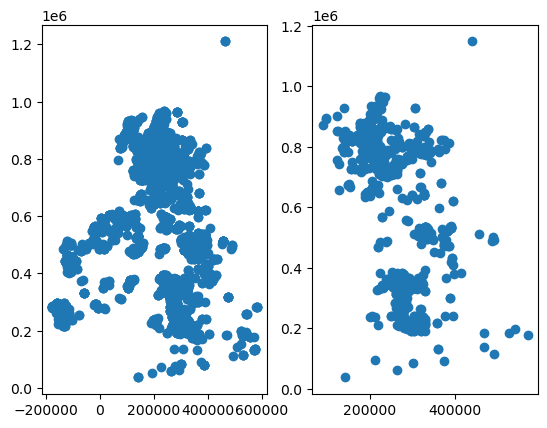

In [13]:
fig, (ax1, ax2) = plt.subplots(1,2)
ax1.scatter(new['x'], new['y'])
ax2.scatter(existing['x'], existing['y'])